# EMNIST Handwriting Recognition

This notebook trains a simple CNN on the **EMNIST** dataset (balanced split) and visualizes how the model learns:

1. Training / validation **Accuracy & Loss** curves  
2. A **Confusion Matrix** for the test set  
3. Examples the network **mis‑classifies**



In [2]:
# Step 1 – Imports
!pip install tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00


In [3]:
# Step 2 – Load & Preprocess EMNIST (balanced split)
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/balanced',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

NUM_CLASSES = ds_info.features['label'].num_classes
IMG_SIZE = ds_info.features['image'].shape[0]  # 28

def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.rot90(image, k=3)
    return image, label

BATCH_SIZE = 128

ds_train = (ds_train
            .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
            .cache()
            .shuffle(10_000)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

ds_test = (ds_test
           .map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH_SIZE)
           .cache()
           .prefetch(tf.data.AUTOTUNE))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.O7CI4K_3.1.0/emnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.O7CI4K_3.1.0/emnist-test.tfrecord*...:   0%|   …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.


In [4]:
# Step 3 – Build the CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,807 (897.68 KB)

 Trainable params: 229,807 (897.68 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Step 4 – Train
EPOCHS = 10
history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=EPOCHS)


Epoch 1/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 92s 102ms/step - accuracy: 0.4500 - loss: 1.9782 - val_accuracy: 0.8202 - val_loss: 0.5557
Epoch 2/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.7517 - loss: 0.7769 - val_accuracy: 0.8410 - val_loss: 0.4765
Epoch 3/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.7832 - loss: 0.6593 - val_accuracy: 0.8510 - val_loss: 0.4408
Epoch 4/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 72s 82ms/step - accuracy: 0.8034 - loss: 0.5975 - val_accuracy: 0.8584 - val_loss: 0.4149
Epoch 5/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 72s 81ms/step - accuracy: 0.8180 - loss: 0.5486 - val_accuracy: 0.8641 - val_loss: 0.3973
Epoch 6/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 71s 80ms/step - accuracy: 0.8275 - loss: 0.5112 - val_accuracy: 0.8681 - val_loss: 0.3903
Epoch 7/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.8335 - loss: 0.4848 - val_accuracy: 0.8668 - val_loss: 0.3841
Epoch 8/10
882/882 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.8437 - loss: 0.4640 -

In [15]:
# Accuracy during training
train_acc = history.history['accuracy'][-1]  # Last epoch
val_acc = history.history['val_accuracy'][-1]  # Last epoch

print(f"Final Training Accuracy: {train_acc * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")


Final Training Accuracy: 85.20%
Final Validation Accuracy: 87.49%


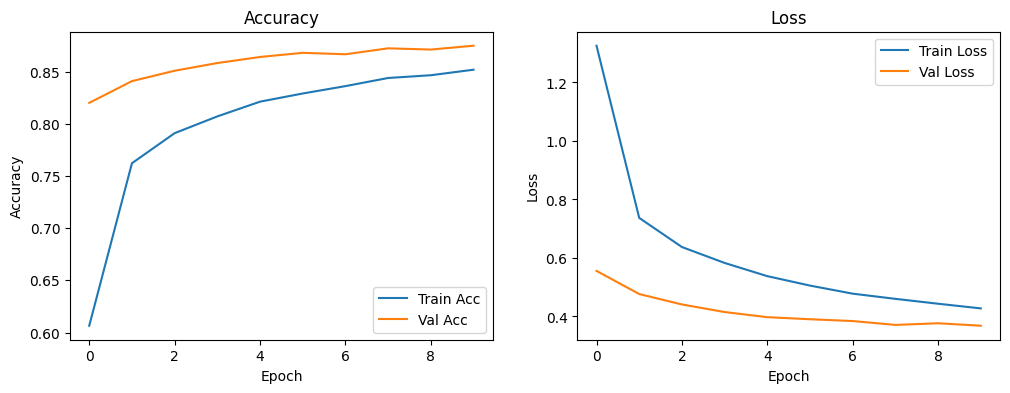

In [10]:
# Step 5 – Accuracy & Loss Curves

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


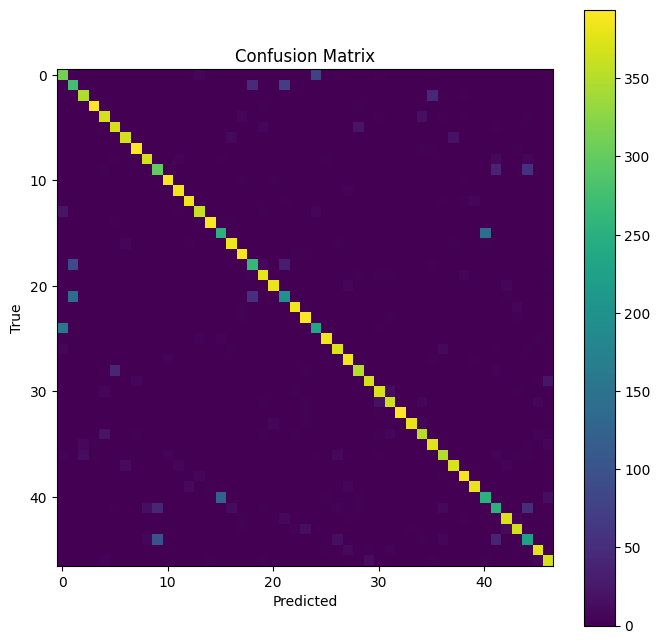

In [11]:
# Step 6 – Confusion Matrix
# Build arrays of true / pred labels

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))

plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()


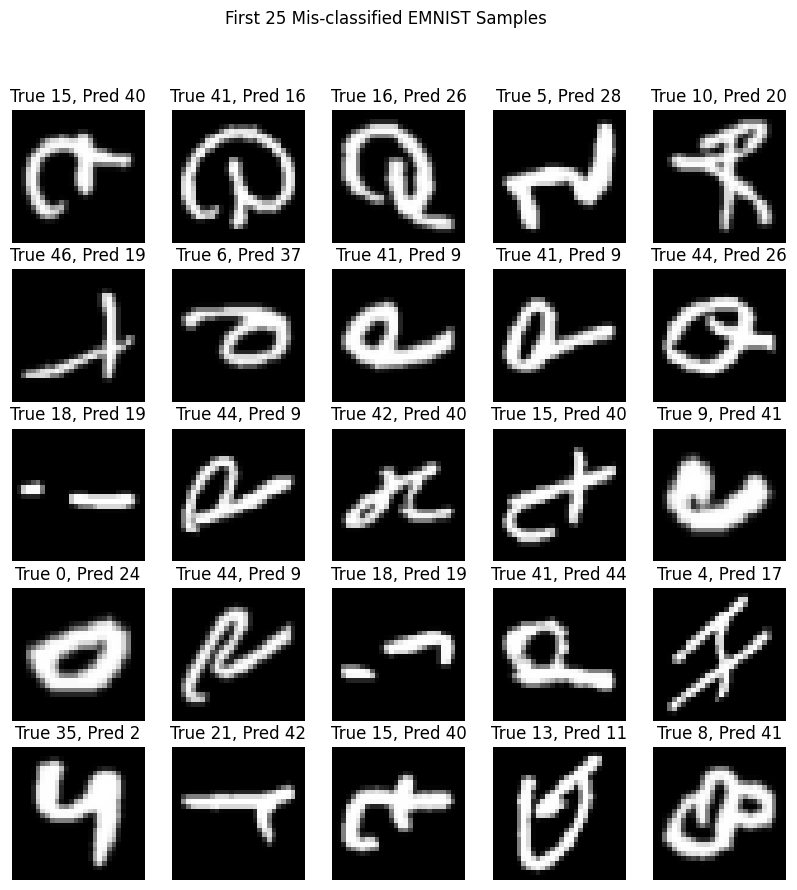

In [13]:
# Step 7 – Show Mis‑classified Examples
import itertools

mis_idx = [i for i, (t,p) in enumerate(zip(y_true, y_pred)) if t!=p][:25]
plt.figure(figsize=(10,10))
for i, idx in enumerate(mis_idx):
    img = tfds.as_numpy(ds_test.unbatch().skip(idx).take(1))
    for im,lbl in img:
        im_disp = np.rot90(im.squeeze(), k=1)
        plt.subplot(5,5,i+1)
        plt.imshow(im_disp, cmap='gray')
        plt.title(f'True {lbl}, Pred {y_pred[idx]}')
        plt.axis('off')
plt.suptitle('First 25 Mis‑classified EMNIST Samples')
plt.show()
